In [395]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import glob # A module to match regular expressions in this case we want to match all csv files in a folder and flush them out!
import calendar
plt.rcParams["figure.figsize"] = (24, 11)
legend_size = 15
plt.rcParams['legend.title_fontsize'] = legend_size
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

# **Section 1: Data Preprocessing**

In [94]:
data_path = "data"

In [268]:
# Lets get all files with their respective paths 
all_csv_files = glob.glob(f'{data_path}/*y.csv')
all_csv_files

['data/monday.csv',
 'data/wednesday.csv',
 'data/thursday.csv',
 'data/tuesday.csv',
 'data/friday.csv']

In [96]:
# Create a function that orders day of week
def order_files_by_day_of_week(files):
    filenames = []
    days = [i.split("/")[1].split(".")[0].title() for i in all_csv_files]
    for ordered_day in list(calendar.day_name):
        if ordered_day in days:
            index = days.index(ordered_day)
            filenames.append(files[index])
    return filenames

In [274]:
# Get ordered files 
files = order_files_by_day_of_week(all_csv_files)
files

['data/monday.csv',
 'data/tuesday.csv',
 'data/wednesday.csv',
 'data/thursday.csv',
 'data/friday.csv']

In [275]:
# Read the files
df_list = [pd.read_csv(i, index_col = 0, parse_dates=True, sep=";") for i in files]

In [277]:
# Get abbreviated weekly names from files 
weekly_names = [i.split("/")[1].split(".")[0][0:3] for i in files]
weekly_names

['mon', 'tue', 'wed', 'thu', 'fri']

In [373]:
# Put dataframe list into a dictionary 
df_dict = {}
count = 0 
for week_name in weekly_names:
    df_dict[week_name] = df_list[count]
    count += 1
calendar.day_name[calendar.firstweekday()]

'Monday'

In [101]:
# Give unique id to a customer and concatenate into one huge dataframe

df_all = [] 
for key in df_dict.keys():
    df = df_dict[key]
    df["day_of_week"] = df.index.day_name()
    df["customer_no"] = df["customer_no"].astype(str)
    df["shortened_day"] = [i[0:3] for i in df["day_of_week"].tolist()]
    df["customer_id"] = df["customer_no"] + "_" + df["shortened_day"]
    df.drop("shortened_day", axis = 1, inplace=True)
    df_all.append(df)

df_all = pd.concat(df_all)

In [102]:
# df_mo = pd.read_csv(f'{data_path}/monday.csv', index_col = 0, parse_dates=True, sep=';')
# df_tu = pd.read_csv(f'{data_path}/tuesday.csv',  index_col = 0,parse_dates=True, sep=';')
# df_we = pd.read_csv(f'{data_path}/wednesday.csv',  index_col = 0,parse_dates=True, sep=';')
# df_th = pd.read_csv(f'{data_path}/thursday.csv',  index_col = 0,parse_dates=True, sep=';')
# df_fr = pd.read_csv(f'{data_path}/friday.csv',  index_col = 0,parse_dates=True, sep=';')


In [103]:
# df_all = pd.concat([df_mo, df_tu, df_we, df_th, df_fr])

In [104]:
df_all.shape

(24877, 4)

In [105]:
# Add hour and minute column
# df_all['date'] = pd.to_datetime(df_all['timestamp'])
df_all["hour"] = df_all.index.hour
df_all["minute"] = df_all.index.minute

In [106]:
# df_all['day'] =df_all['date'].dt.day_name()
# df_all['hour'] =df_all['date'].dt.hour
# df_all.head()

In [107]:
df_all['location'].value_counts()

checkout    7417
fruit       5122
dairy       4679
drinks      3905
spices      3754
Name: location, dtype: int64

# **Section 2: Real Deal (Answering the questions)**

# 1. Calculate the total number of customers in each section

<AxesSubplot:xlabel='location', ylabel='count'>

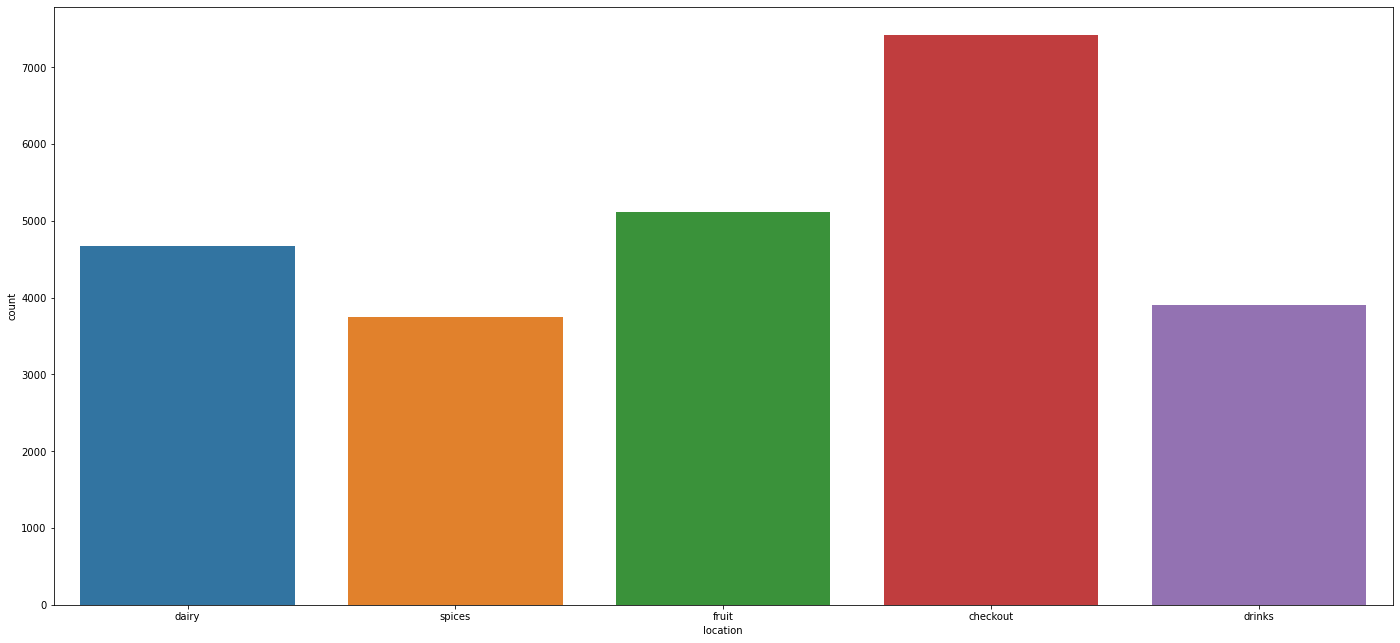

In [375]:
sns.countplot(x=df_all.location)

# 2a. Calculate the total number of customers in each section over time (day)

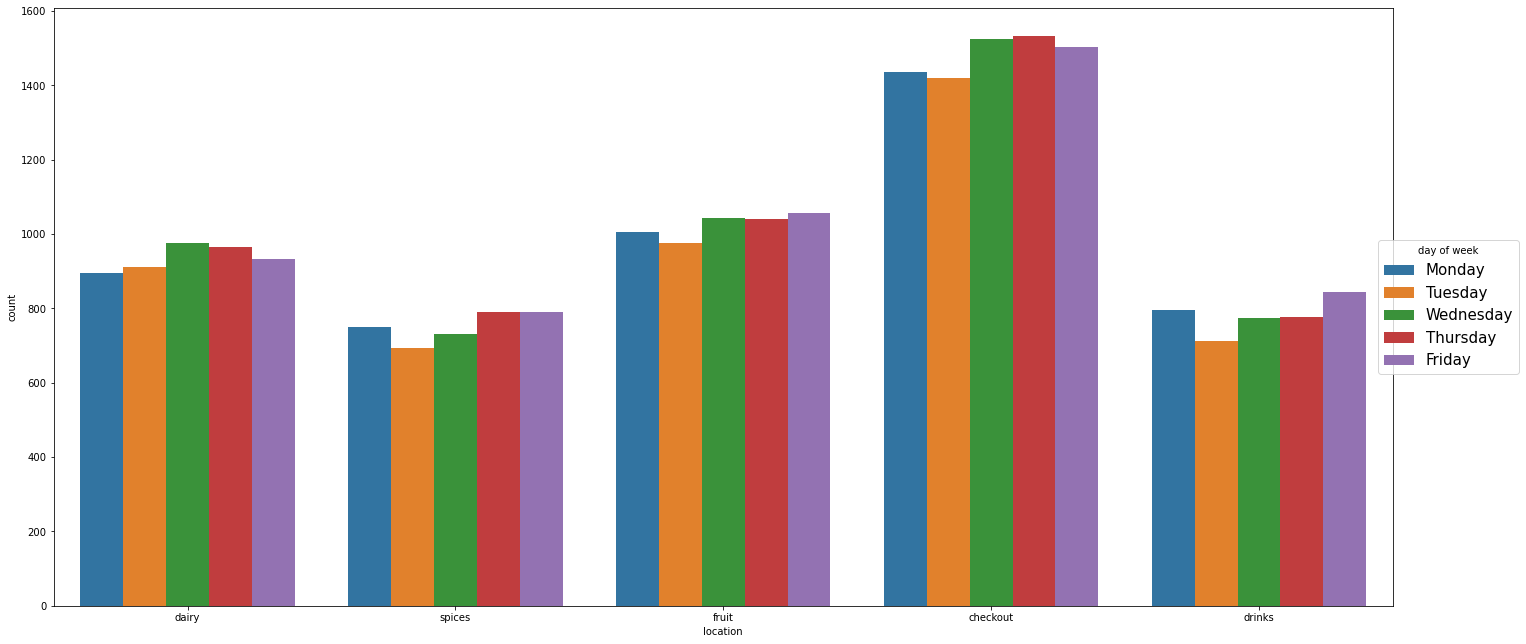

In [376]:
sns.countplot(x=df_all.location, hue=df_all.day_of_week)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc=5, title = "day of week", fontsize = 15)a

# 2b. Calculate the total number of customers in each section over time: hour

,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
location,,,,,,,,,,,,,,,
checkout,454,677,455,427,342,384,514,496,412,518,556,630,755,492,305
dairy,275,455,291,294,210,225,340,319,233,337,360,425,466,298,151
drinks,278,348,231,198,150,188,238,229,190,272,294,361,441,307,180
fruit,299,468,336,270,244,247,389,345,316,353,410,453,507,312,173
spices,238,342,207,242,165,208,273,261,184,262,269,346,389,246,122


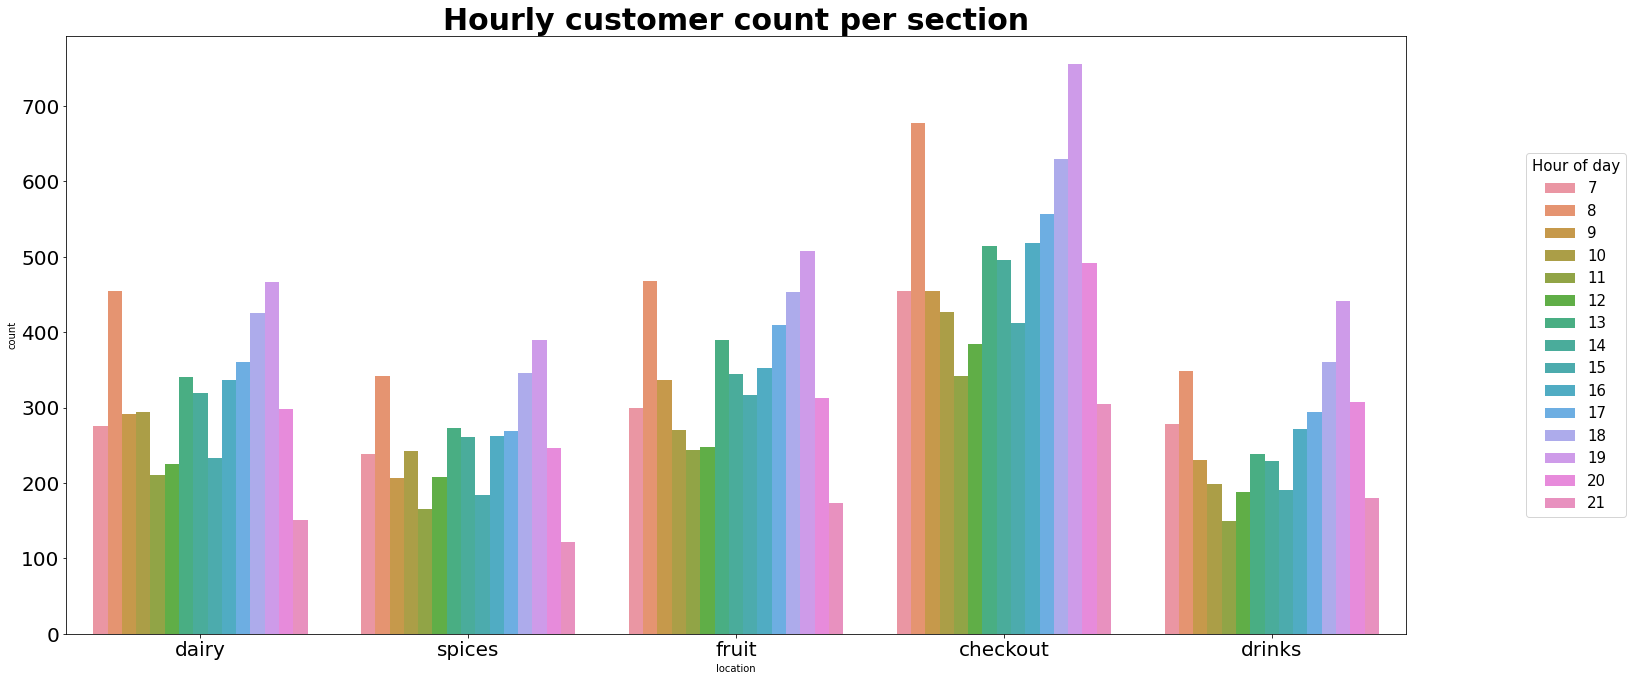

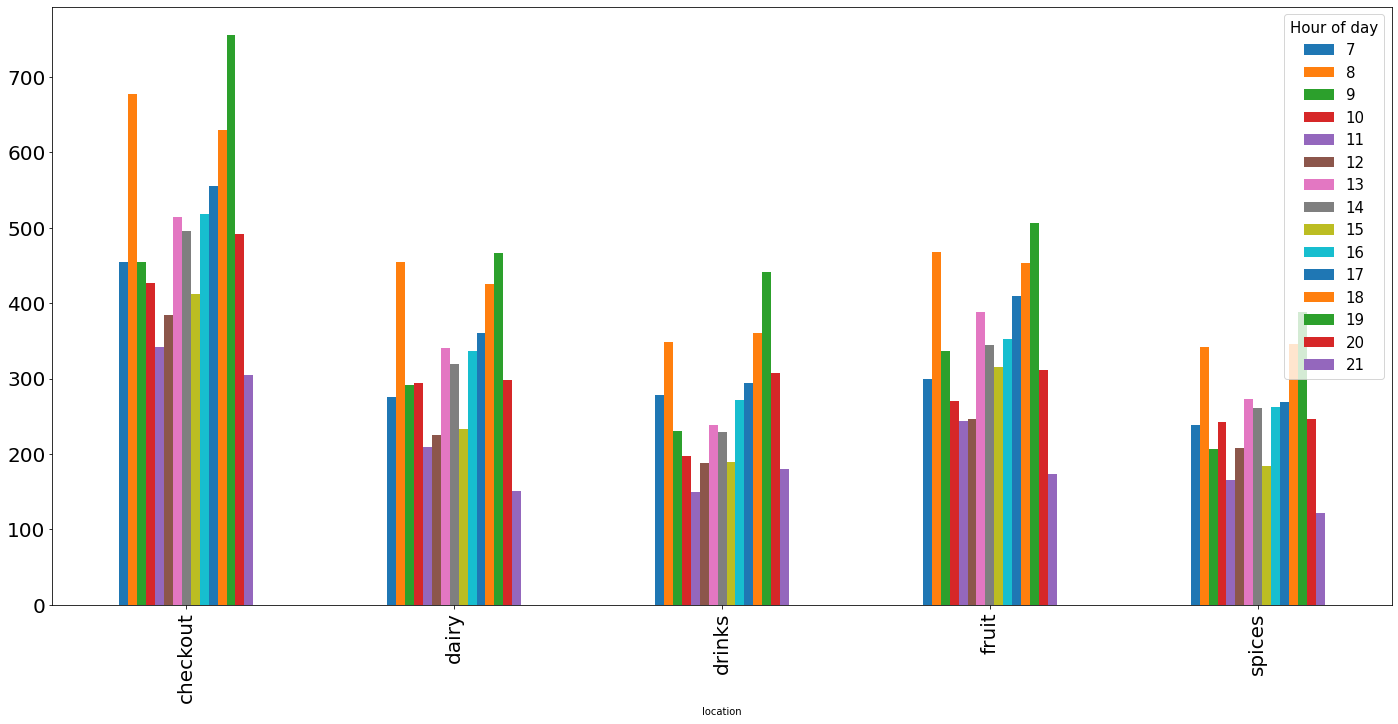

In [396]:
sns.countplot(x=df_all.location, hue=df_all.hour)
plt.legend(bbox_to_anchor=(1.17, 0.5), loc=5, title="Hour of day", prop = {"size": legend_size})
plt.title("Hourly customer count per section", fontsize = 30, fontweight = "bold")

df_all[["customer_id"]].groupby(df_all["location"]).agg("count")

def checkout_by_hour(df):
    # Get all hour timesteps 
    hours = [i for i in df.index.hour.unique()]
    df_list = []
    for hour in hours: 
        df_hour = df[df.index.hour == hour]
        df_list.append(pd.DataFrame(df_hour["customer_id"].groupby(df_hour["location"]).count()))
    final_df = pd.concat(df_list, axis = 1)
    final_df.columns = hours 
    return final_df

my_df = checkout_by_hour(df_all)

#sns.heatmap(my_df)
my_df.plot(kind = "bar")
plt.legend(prop={"size": legend_size}, title = "Hour of day")


my_df

# 2c. Calculate the total number of customers in each section over time: minute

Text(0.5, 1.0, 'Minute customer count per section')

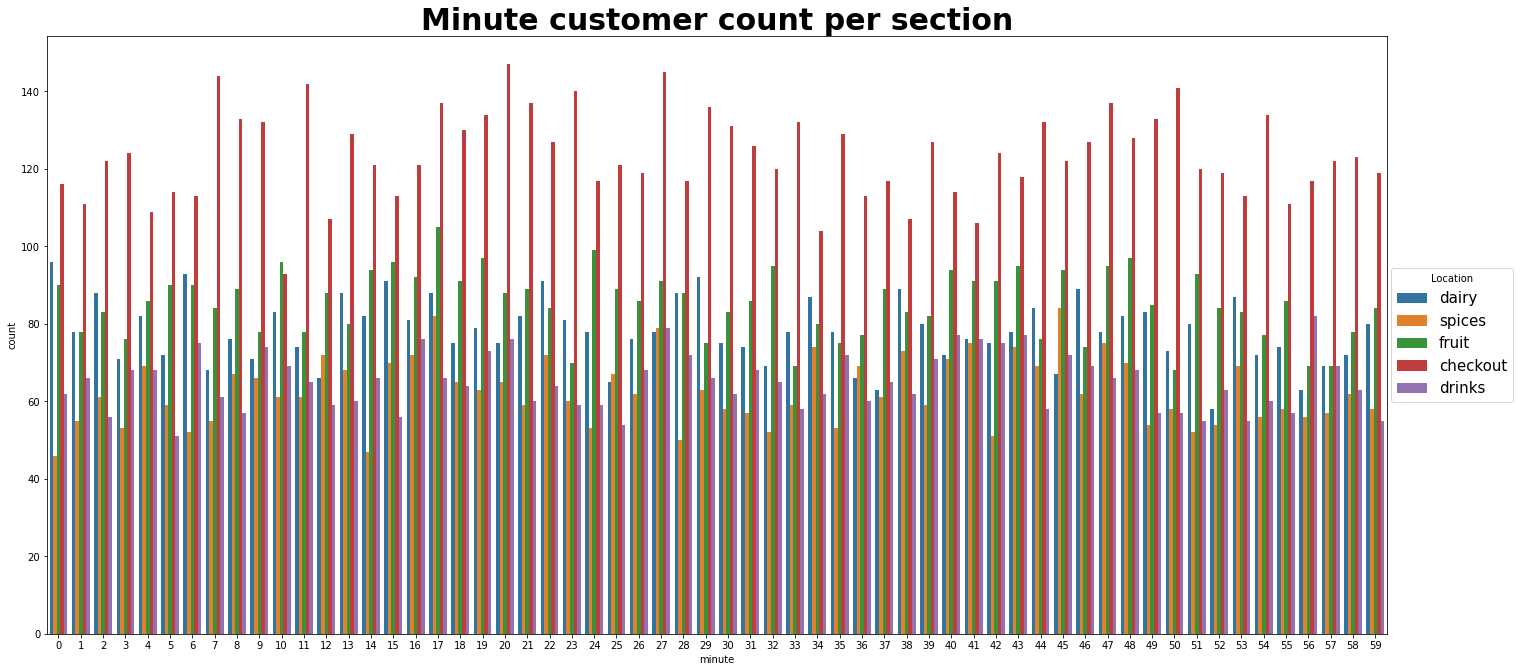

In [132]:

sns.countplot(hue=df_all.location, x=df_all.minute)
plt.legend(bbox_to_anchor=(1.1, 0.5), loc=5, title = "Location", fontsize = 15)
plt.title("Minute customer count per section", fontsize = 30, fontweight = "bold")

# 3. Display the number of customers at checkout over time

Text(0.5, 1.0, 'Customer checkout per hour')

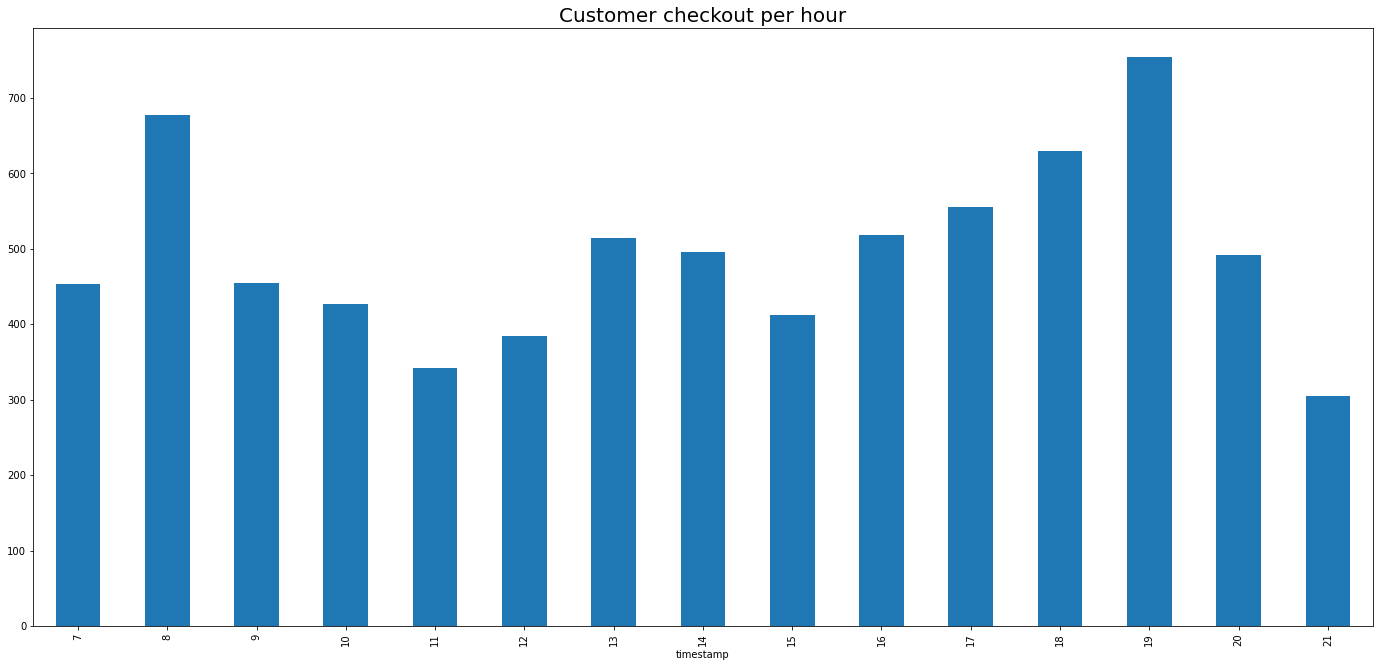

In [172]:
df_checkout = df_all[df_all["location"] == "checkout"]
#sns.countplot(x=df_checkout["location"], hue = df_checkout.index.hour)
df_checkout["location"].groupby(df_checkout.index.hour).count().plot(kind = "bar")
plt.title("Customer checkout per hour", fontsize = 20)


In [173]:
# sns.countplot(x=df_all.location=='checkout', hue=df_all.hour)
# plt.legend(bbox_to_anchor=(1.17, 0.5), loc=5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 4. Calculate the time each customer spent in the market


## Calculate the time each customer spent in the supermarket

In [ ]:
# Lets first calculate duration

In [366]:
customer_ids = [i for i in df_all["customer_id"].unique()]

duration = []
time_in = []
time_out = []

for customer_id in customer_ids:

    df_day = df_all[df_all["customer_id"] == customer_id]

    #print(df_day)
    if "checkout" in df_day["location"].tolist():
        min_time = df_day.index.min()
        max_time = df_day.index.max()
        diff = (max_time - min_time).seconds
        duration.append(diff)
        time_in.append(str(min_time))
        time_out.append(str(max_time))
   
    else:
        min_time = df_day.index.min()
        construct_last_time = datetime.strptime(f'{str(max_time).split(" ")[0]} 21:59:59', "%Y-%m-%d %H:%M:%S")
        diff = construct_last_time - min_time
        diff = diff.seconds
        duration.append(diff)  
        time_in.append(str(min_time))
        time_out.append(str(construct_last_time))
      

In [368]:
# Create a new dataframe with customer id date in, date out and duration inside supermarket
df_duration = pd.DataFrame({"customer_id": customer_ids, "entry time": time_in, "exit time": time_out, "duration (secs)": duration})
df_duration



,customer_id,entry time,exit time,duration (secs)
0,1_Mon,2019-09-02 07:03:00,2019-09-02 07:05:00,120
1,2_Mon,2019-09-02 07:03:00,2019-09-02 07:06:00,180
2,3_Mon,2019-09-02 07:04:00,2019-09-02 07:06:00,120
3,4_Mon,2019-09-02 07:04:00,2019-09-02 07:08:00,240
4,5_Mon,2019-09-02 07:04:00,2019-09-02 07:05:00,60
...,...,...,...,...
7440,1506_Fri,2019-09-06 21:48:00,2019-09-06 21:59:59,719
7441,1507_Fri,2019-09-06 21:48:00,2019-09-06 21:50:00,120
7442,1508_Fri,2019-09-06 21:48:00,2019-09-06 21:50:00,120
7443,1509_Fri,2019-09-06 21:50:00,2019-09-06 21:59:59,599


In [ ]:
# Calculate the total number of customers in the supermarket over time